
# Experiment 3 — LoRA Adapters + Bayesian Approximation (Laplace/Fisher) for 3‑way MCQ

**Goal.** Start from a small pretrained text encoder, add **LoRA adapters** to a few attention/projection modules, fine‑tune only those adapters on a **3‑option multiple‑choice** task, then place a **Bayesian posterior** over the *adapter parameters* using a simple **diagonal Laplace / Fisher approximation**.

**Why this is nice (for education + speed):**
- We avoid sampling full Transformer weights. We only adapt a tiny set of parameters (LoRA).
- After fine‑tuning, we build a Gaussian posterior around the MAP solution using the **empirical Fisher diagonal** (i.e., squared gradients under the data).
- Posterior predictive = **Monte Carlo average** over a few draws of adapter weights.
- We can then plot the same **calibration** and **abstention** figures as in the previous experiments.



## 0) Setup

Install (inside your Pipenv or environment):
```bash
pipenv run pip install "torch>=2.2" transformers peft accelerate datasets     scikit-learn pandas matplotlib numpy tqdm
```
> On Apple Silicon without GPU, this runs on CPU and is fine for small models.



## 1) Data — 3‑option MCQ
Expecting a pandas DataFrame `df` with columns:
- `question`, `option_a`, `option_b`, `option_c`, `label` (0,1,2)

Below we create a small default dataset if `df` is not defined yet.


In [108]:

import pandas as pd

if 'df' not in globals():
    rows = [
        # label 0
        {"question": "Which planet is known as the Red Planet?", "option_a": "Mars", "option_b": "Venus", "option_c": "Jupiter", "label": 0},
        {"question": "Capital of France?", "option_a": "Paris", "option_b": "Berlin", "option_c": "Madrid", "label": 0},
        {"question": "Which animal barks?", "option_a": "dog", "option_b": "cat", "option_c": "cow", "label": 0},
        {"question": "Which country hosted the 2016 Summer Olympics?", "option_a": "Brazil", "option_b": "China", "option_c": "UK", "label": 0},
        {"question": "Who discovered penicillin?", "option_a": "Alexander Fleming", "option_b": "Marie Curie", "option_c": "Louis Pasteur", "label": 0},
        {"question": "What is the capital of Japan?", "option_a": "Kyoto", "option_b": "Tokyo", "option_c": "Osaka", "label": 0},
        {"question": "Which is the fastest land animal?", "option_a": "Cheetah", "option_b": "Horse", "option_c": "Lion", "label": 0},
        {"question": "Who wrote 'Romeo and Juliet'?", "option_a": "William Shakespeare", "option_b": "Charles Dickens", "option_c": "Mark Twain", "label": 0},
        {"question": "Which gas is essential for respiration?", "option_a": "Oxygen", "option_b": "Carbon monoxide", "option_c": "Helium", "label": 0},
        {"question": "Which continent is Egypt located in?", "option_a": "Africa", "option_b": "Asia", "option_c": "Europe", "label": 0},
        # label 1
        {"question": "What color are bananas when ripe?", "option_a": "red", "option_b": "yellow", "option_c": "blue", "label": 1},
        {"question": "How many continents are there?", "option_a": "Five", "option_b": "Seven", "option_c": "Six", "label": 1},
        {"question": "Who painted the Mona Lisa?", "option_a": "Michelangelo", "option_b": "Leonardo da Vinci", "option_c": "Raphael", "label": 1},
        {"question": "What is the boiling point of water at sea level (°C)?", "option_a": "90", "option_b": "100", "option_c": "110", "label": 1},
        {"question": "2 + 2 equals?", "option_a": "3", "option_b": "4", "option_c": "5", "label": 1},
        {"question": "How many players are on a standard soccer team (on field)?", "option_a": "9", "option_b": "11", "option_c": "12", "label": 1},
        {"question": "Which element has the symbol 'O'?", "option_a": "Osmium", "option_b": "Oxygen", "option_c": "Gold", "label": 1},
        {"question": "Which shape has three sides?", "option_a": "Square", "option_b": "Triangle", "option_c": "Pentagon", "label": 1},
        {"question": "What is the largest mammal?", "option_a": "Elephant", "option_b": "Blue Whale", "option_c": "Giraffe", "label": 1},
        {"question": "Which ocean is the largest?", "option_a": "Pacific Ocean", "option_b": "Atlantic Ocean", "option_c": "Indian Ocean", "label": 1},
        # label 2
        {"question": "Which organ pumps blood in the human body?", "option_a": "Lungs", "option_b": "Brain", "option_c": "Heart", "label": 2},
        {"question": "The Sun is a ...", "option_a": "planet", "option_b": "comet", "option_c": "star", "label": 2},
        {"question": "Which metal is liquid at room temperature?", "option_a": "Mercury", "option_b": "Iron", "option_c": "Aluminum", "label": 2},
        {"question": "The Great Wall is located in which country?", "option_a": "India", "option_b": "China", "option_c": "Japan", "label": 2},
        {"question": "Which planet has the most moons?", "option_a": "Jupiter", "option_b": "Saturn", "option_c": "Neptune", "label": 2},
        {"question": "Which gas do humans exhale?", "option_a": "Oxygen", "option_b": "Carbon dioxide", "option_c": "Nitrogen", "label": 2},
        {"question": "Which city is known as the Big Apple?", "option_a": "New York", "option_b": "Los Angeles", "option_c": "Chicago", "label": 0},
        {"question": "Which country is both in Europe and Asia?", "option_a": "Turkey", "option_b": "Spain", "option_c": "Mexico", "label": 0},
        {"question": "Which month has 28 days?", "option_a": "February", "option_b": "June", "option_c": "November", "label": 0},
        {"question": "What is the chemical symbol for gold?", "option_a": "Ag", "option_b": "Au", "option_c": "Pb", "label": 1},
    ]
    df = pd.DataFrame(rows)

df.head()


,question,option_a,option_b,option_c,label
0,Which planet is known as the Red Planet?,Mars,Venus,Jupiter,0
1,Capital of France?,Paris,Berlin,Madrid,0
2,Which animal barks?,dog,cat,cow,0
3,Which country hosted the 2016 Summer Olympics?,Brazil,China,UK,0
4,Who discovered penicillin?,Alexander Fleming,Marie Curie,Louis Pasteur,0



## 2) Split


In [109]:

from sklearn.model_selection import train_test_split
import numpy as np

y = df['label'].values.astype(int)
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=y if len(np.unique(y))>1 else None)
len(train_df), len(test_df)


(18, 12)


## 3) Model — Tiny encoder + LoRA adapters

We use a **very small** encoder to keep it fast (e.g., `prajjwal1/bert-tiny`). We score each (question, option) pair separately, then **softmax across the 3 options**.


In [168]:

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel, AutoModelForMultipleChoice
from peft import LoraConfig, get_peft_model, TaskType

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_name = "prajjwal1/bert-tiny"  # small & fast
#model_name = "microsoft/MiniLM-L12-H384-uncased"
# model_name = "prajjwal1/bert-small"
model_name = "bert-base-uncased"

tok = AutoTokenizer.from_pretrained(model_name)
base = AutoModel.from_pretrained(model_name).to(device)
base.eval()

# Freeze base model
for p in base.parameters():
    p.requires_grad_(False)

# Multiple-choice model (has a classification head that returns logits per choice)
base_mc = AutoModelForMultipleChoice.from_pretrained(model_name).to(device)

# LoRA for sequence classification (MC is a seq-classification task)
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["query", "key", "value", "dense"],
    bias="none",
)
model = get_peft_model(base_mc, lora_cfg).to(device)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)



Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



## 4) Dataloaders — turn MCQ into pairwise inputs

Each example yields 3 encodings: (question, option_a/b/c) → we get [CLS] and score each separately.


In [165]:
# ==== Load CommonsenseQA and build DataLoaders (N-choice) ====

# pip install -q datasets  # run once if you don't have it
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# 1) Load the dataset (train/validation/test)
csqa = load_dataset("commonsense_qa")
print(csqa)  # shows split sizes


class CommonsenseQADataset(Dataset):
    def __init__(self, hf_split):
        self.data = hf_split
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        q = ex["question"]
        opts = ex["choices"]["text"]           # list of 5 options
        labs = ex["choices"]["label"]          # ['A','B','C','D','E']
        y = labs.index(ex["answerKey"])
        return q, opts, y

def collate(batch, max_length=128):
    """
    Returns dict with:
      input_ids:      (B, C, T)
      attention_mask: (B, C, T)
      token_type_ids: (B, C, T)  (BERT-like models)
      labels:         (B,)
    """
    qs, opts_list, labels = zip(*batch)           # B items
    C = max(len(o) for o in opts_list)
    # tokenize each (q, option) pair; group by item
    all_enc = []
    for q, opts in zip(qs, opts_list):
        enc = tok([q]*len(opts), list(opts), truncation=True, padding="max_length",
                  max_length=max_length, return_tensors="pt")
        all_enc.append(enc)

    # pad to common C if ever needed (CSQA uses constant C=5)
    def pad_to_C(enc, C):
        for k in ["input_ids", "attention_mask", "token_type_ids"]:
            if k in enc:
                if enc[k].size(0) < C:
                    pad_rows = C - enc[k].size(0)
                    pad = torch.zeros(pad_rows, enc[k].size(1), dtype=enc[k].dtype)
                    if k == "attention_mask": pad = pad  # zeros are fine
                    enc[k] = torch.cat([enc[k], pad], dim=0)
        return enc

    enc_stacked = {}
    for k in ["input_ids", "attention_mask", "token_type_ids"]:
        if k in all_enc[0]:
            enc_stacked[k] = torch.stack([pad_to_C(enc, C)[k] for enc in all_enc], dim=0)  # (B, C, T)

    batch_out = {k: v.to(device) for k, v in enc_stacked.items()}
    batch_out["labels"] = torch.tensor(labels, dtype=torch.long, device=device)
    return batch_out

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 9741
    })
    validation: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 1221
    })
    test: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 1140
    })
})


In [172]:
from datasets import load_dataset

csqa = load_dataset("commonsense_qa")

# take the first n examples after a shuffle
N_TRAIN = 200
N_VAL   = 50

train_split = csqa["train"].shuffle(seed=42).select(range(N_TRAIN))
val_split   = csqa["validation"].shuffle(seed=42).select(range(N_VAL))

train_ds = CommonsenseQADataset(train_split)
val_ds   = CommonsenseQADataset(val_split)  # use as test/val

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, collate_fn=collate)



## 5) Fine‑tune LoRA adapters (MAP estimate)

We optimize only **LoRA adapter params** and the **linear head**, with cross‑entropy over the 3 options.


In [173]:
from tqdm import tqdm

EPOCHS = 3
for ep in range(1, EPOCHS+1):
    # train
    model.train()
    tot, correct, loss_sum = 0, 0, 0.0
    for batch in tqdm(train_loader, desc=f"ep {ep} [train]"):
        out = model(**batch)                 # accepts labels; returns loss + logits
        loss = out.loss
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item() * batch["labels"].size(0)
        pred = out.logits.argmax(dim=1)
        correct += (pred == batch["labels"]).sum().item()
        tot += batch["labels"].size(0)
    tr_loss = loss_sum / max(tot, 1)
    tr_acc  = correct / max(tot, 1)

    # eval
    model.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"ep {ep} [eval]"):
            out = model(**batch)
            loss_sum += out.loss.item() * batch["labels"].size(0)
            pred = out.logits.argmax(dim=1)
            correct += (pred == batch["labels"]).sum().item()
            tot += batch["labels"].size(0)
    te_loss = loss_sum / max(tot, 1)
    te_acc  = correct / max(tot, 1)
    print(f"epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} | val loss {te_loss:.3f} acc {te_acc:.3f}")

ep 1 [eval]: 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


epoch 01 | train loss 1.597 acc 0.260 | val loss 1.571 acc 0.160


ep 2 [eval]: 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


epoch 02 | train loss 1.578 acc 0.245 | val loss 1.551 acc 0.200


ep 3 [eval]: 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]

epoch 03 | train loss 1.567 acc 0.320 | val loss 1.532 acc 0.300



## 6) Diagonal Laplace / Empirical Fisher over LoRA + head

We approximate the posterior around the MAP θ with a **diagonal Gaussian**.  
For a batch, we accumulate the **squared gradients of log‑likelihood** (equivalently, gradients of CE) as the **empirical Fisher diagonal**.


In [174]:
# ==== Laplace snapshot utilities (PEFT-wrapped Multiple-Choice model) ====

import torch
import numpy as np
from tqdm import tqdm, trange

device = next(model.parameters()).device  # infer device from model

def get_trainable_snapshot():
    """Capture the CURRENT set of trainable params (LoRA + classifier head)."""
    params = [p for p in model.parameters() if p.requires_grad]
    shapes = [p.shape for p in params]
    numel  = sum(p.numel() for p in params)
    return params, shapes, numel

trainable, shapes, numel = get_trainable_snapshot()

def pack(params):
    return torch.cat([p.detach().reshape(-1) for p in params]).to(device)

def pack_grads(params):
    parts = []
    for p in params:
        if p.grad is None:
            parts.append(torch.zeros_like(p).reshape(-1))
        else:
            parts.append(p.grad.detach().reshape(-1))
    return torch.cat(parts).to(device)

def unpack(vec):
    out = []
    i = 0
    for shp in shapes:
        n = int(torch.tensor(shp).prod().item())
        out.append(vec[i:i+n].view(shp).clone())
        i += n
    return out

@torch.no_grad()
def set_params_from_vector(vec):
    """Write a flat vector back into the CURRENT trainable params (same ordering as snapshot)."""
    parts = unpack(vec)
    i = 0
    for p in model.parameters():
        if p.requires_grad:
            p.copy_(parts[i]); i += 1

theta_map = pack(trainable)  # MAP point (post-training weights)
print(f"[Laplace] trainable tensors: {len(trainable)} | numel: {numel:,}")

[Laplace] trainable tensors: 148 | numel: 1,340,161


In [176]:
# ==== Empirical Fisher diagonal for Multiple-Choice model ====

import torch.nn as nn

def fisher_diag(train_loader, num_batches=None, use_train_mode=False, show_progress=True):
    """
    Empirical Fisher diagonal: E[(∂/∂θ log p(y|x,θ))^2] estimated by squared grads of CE loss.
    Uses the model's built-in MC loss (so pass labels in the batch).
    """
    # Mode (dropout behavior)
    if use_train_mode:
        model.train()
    else:
        model.eval()

    F = torch.zeros(numel, device=device)
    count = 0

    it = enumerate(train_loader)
    if show_progress:
        it = tqdm(it, total=None if num_batches is None else num_batches, desc="Fisher", leave=False)

    for b, batch in it:
        if num_batches and b >= num_batches:
            break

        # Ensure the batch has labels; model handles loss internally
        batch = {k: v for k, v in batch.items()}  # shallow copy
        model.zero_grad(set_to_none=True)

        out = model(**batch)         # expects labels; returns .loss
        loss = out.loss
        loss.backward()

        g = pack_grads(trainable)    # grads for CURRENT trainable set
        if g.numel() != numel:
            raise RuntimeError(f"Grad vector {g.numel()} != numel snapshot {numel}. Rebuild snapshot.")
        F += g.pow(2)
        count += 1

    if count > 0:
        F /= count
    return F + 1e-8  # jitter

# Compute F on your (sub)set
F_diag = fisher_diag(train_loader, num_batches=None, use_train_mode=False, show_progress=True)
print("F_diag:", tuple(F_diag.shape), "mean:", F_diag.mean().item())

F_diag: (1340161,) mean: 1.56463538587559e-05



## 7) Posterior predictive via Gaussian samples over θ

We assume a **Gaussian posterior**: \( \theta \sim \mathcal{N}(\theta_{MAP}, \Sigma) \)  
with diagonal \( \Sigma = (\lambda \cdot F)^{-1} \). Hyper‑parameter \(\lambda\) acts like precision from a simple Gaussian prior / damping.


In [177]:
# ==== Monte Carlo posterior predictive over choices (N-choice) ====

@torch.no_grad()
def predict_proba_mc(loader, S=30, lam=1.0, show_progress=True):
    """
    Returns mean probs over S parameter samples: shape (N_total_items, C).
    Assumes each batch has consistent C (true for CSQA).
    """
    model.eval()

    assert F_diag.numel() == numel, f"F_diag {F_diag.numel()} != numel {numel}. Rebuild snapshot."
    var = 1.0 / (lam * F_diag)     # (numel,)
    std = var.sqrt()
    theta0 = pack(trainable)       # cache current params

    all_probs = []
    outer = trange(S, desc="MC θ samples", leave=False, disable=not show_progress)
    for _ in outer:
        theta_s = theta_map + torch.randn_like(std) * std
        set_params_from_vector(theta_s)

        batch_probs = []
        inner = loader if not show_progress else tqdm(loader, desc="MC batches", leave=False)
        for batch in inner:
            batch_nolabels = {k: v for k, v in batch.items() if k != "labels"}  # no labels at predict time
            out = model(**batch_nolabels)   # logits: (B, C)
            p = torch.softmax(out.logits, dim=1)  # (B, C)
            batch_probs.append(p.detach().cpu())
        all_probs.append(torch.cat(batch_probs, dim=0))

    # Restore original params
    set_params_from_vector(theta0)

    P = torch.stack(all_probs, dim=0).mean(dim=0).cpu().numpy()  # (N_total, C)
    return P

In [178]:
# ==== Example usage: MC posterior predictive on train/val ====

S_MC = 30
LAM  = 1.0

p_tr = predict_proba_mc(train_loader, S=S_MC, lam=LAM, show_progress=True)
p_te = predict_proba_mc(val_loader,   S=S_MC, lam=LAM, show_progress=True)
print("Shapes -> p_tr:", p_tr.shape, "p_te:", p_te.shape)

# Collect labels back from loaders (same order)
@torch.no_grad()
def collect_labels(loader):
    ys = []
    for batch in loader:
        ys.append(batch["labels"].detach().cpu().numpy())
    return np.concatenate(ys, axis=0)

y_tr = collect_labels(train_loader).astype(int)
y_te = collect_labels(val_loader).astype(int)

def accuracy_from_probs(p, y):
    return float((p.argmax(axis=1) == y).mean())

print(f"Acc train: {accuracy_from_probs(p_tr, y_tr):.3f} | val: {accuracy_from_probs(p_te, y_te):.3f}")

Shapes -> p_tr: (200, 5) p_te: (50, 5)
Acc train: 0.185 | val: 0.160



## 8) Metrics: Accuracy, Reliability Diagram, Selective Prediction


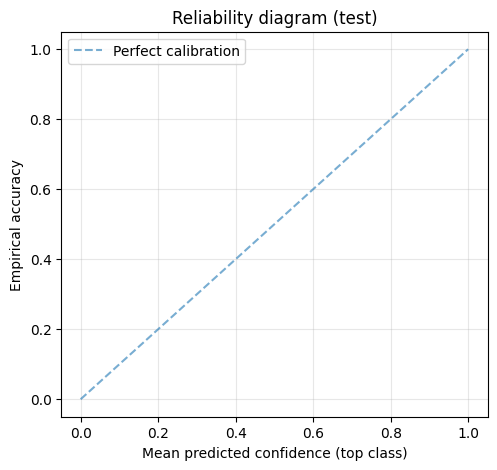

ECE (test): 0.000


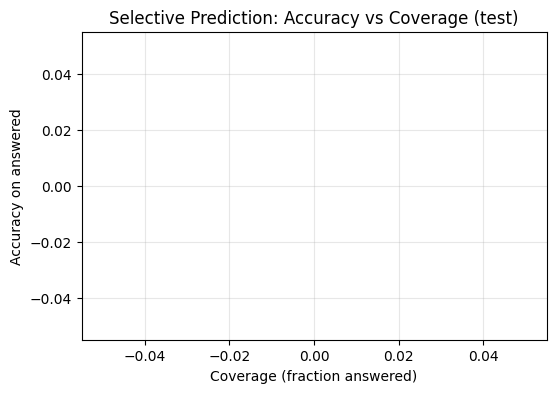

In [180]:
# ==== Accuracy, Reliability Diagram, and Selective Prediction (N-choice) ====

import numpy as np
import matplotlib.pyplot as plt


# 4) Reliability diagram (top-class confidence vs empirical accuracy)
def reliability_points(p, y, n_bins=15):
    conf = p.max(axis=1)
    yhat = p.argmax(axis=1)
    correct = (yhat == y).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    mids, accs, confs, counts = [], [], [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (conf >= lo) & (conf < hi) if i < n_bins-1 else (conf >= lo) & (conf <= hi)
        if sel.any():
            mids.append(0.5*(lo+hi))
            accs.append(correct[sel].mean())
            confs.append(conf[sel].mean())
            counts.append(sel.sum())
    return np.array(mids), np.array(accs), np.array(confs), np.array(counts)

mids_te, accs_te, confs_te, cnts_te = reliability_points(p_te, y_te, n_bins=15)

plt.figure(figsize=(5.5,5))
plt.plot([0,1], [0,1], '--', alpha=0.6, label="Perfect calibration")
plt.scatter(confs_te, accs_te, s=np.clip(cnts_te, 10, 150), alpha=0.8)
for c,a in zip(confs_te, accs_te):
    plt.plot([c,c],[c,a], alpha=0.25)  # calibration error per bin
plt.xlabel("Mean predicted confidence (top class)")
plt.ylabel("Empirical accuracy")
plt.title("Reliability diagram (test)")
plt.grid(True, alpha=0.3)
plt.legend(); plt.show()

# Optional: Expected Calibration Error (ECE)
def expected_calibration_error(p, y, n_bins=15):
    conf = p.max(axis=1)
    yhat = p.argmax(axis=1)
    correct = (yhat == y).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    N = len(y)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (conf >= lo) & (conf < hi) if i < n_bins-1 else (conf >= lo) & (conf <= hi)
        if sel.any():
            gap = abs(correct[sel].mean() - conf[sel].mean())
            ece += (sel.sum()/N) * gap
    return float(ece)

ece_te = expected_calibration_error(p_te, y_te, n_bins=15)
print(f"ECE (test): {ece_te:.3f}")

# 5) Selective prediction: accuracy vs coverage
def evaluate_with_abstention(probs, y_true, tau=0.5):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    answered = conf >= tau
    coverage = answered.mean()
    acc = float("nan") if coverage == 0 else (pred[answered] == y_true[answered]).mean()
    return coverage, acc

# Adaptive thresholds from the data (ensures non-empty curve)
conf_te = p_te.max(axis=1)
taus = np.r_[0.0, np.sort(np.unique(np.round(conf_te, 4))), 0.999]

cov_acc = np.array([evaluate_with_abstention(p_te, y_te, tau=t) for t in taus])
coverages, accs = cov_acc[:,0], cov_acc[:,1]
mask = ~np.isnan(accs)

plt.figure(figsize=(6,4))
plt.plot(coverages[mask], accs[mask], marker="o")
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered")
plt.title("Selective Prediction: Accuracy vs Coverage (test)")
plt.grid(True, alpha=0.3)
plt.show()


## 9) Per‑question posterior predictive (mean ± 1σ) with markers


In [128]:
@torch.no_grad()
def posterior_samples_for_loader(dataloader, S=30, lam=1.0):
    base_lora.eval(); head.eval()
    var = 1.0 / (lam * F_diag); std = var.sqrt()
    theta0 = pack(trainable)
    all_P = []
    for _ in range(S):
        theta_s = theta_map + torch.randn_like(std) * std
        set_params_from_vector(theta_s)
        probs_batches = []
        for enc, map_idx, opt_pos, gold in dataloader:
            out = base_lora(
                input_ids=enc.get("input_ids"),
                attention_mask=enc.get("attention_mask"),
                token_type_ids=enc.get("token_type_ids"),
            )
            scores_flat = forward_scores(out, head, attn_mask=enc.get("attention_mask"))
            N = gold.shape[0]
            C = int(opt_pos.max().item()) + 1
            scoresC = regroup_scores(scores_flat, map_idx, opt_pos, N, C)
            p = torch.softmax(scoresC, dim=1)
            probs_batches.append(p.detach().cpu().numpy())
        all_P.append(np.concatenate(probs_batches, axis=0))
    set_params_from_vector(theta0)
    return np.stack(all_P, axis=0)  # (S, N, C)

In [129]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

def plot_single_event(mean, std, y_true=None, class_names=None, entry_id=None):
    C = mean.shape[0]
    xs = np.arange(C)
    labels = class_names if class_names is not None else [chr(ord('A')+i) for i in range(C)]
    plt.errorbar(xs, mean, yerr=std, fmt="none", ecolor="k", capsize=5)
    plt.plot(xs, mean, "o", color="k", markersize=6)
    y_pred = int(mean.argmax())
    plt.plot(xs[y_pred], mean[y_pred], "o", color="blue", markersize=10)
    if y_true is not None:
        plt.plot(xs[y_true], mean[y_true], marker="*", color="red", markersize=14)
    plt.xticks(xs, labels); plt.ylim(0,1); plt.ylabel("Probability"); plt.xlabel("Category")
    plt.title(f"Posterior for entry {entry_id}" if entry_id is not None else "Posterior (single question)")
    legend_elements = [
        Line2D([0],[0], marker="o", color="k",   linestyle="none", markersize=6,  label="Posterior (mean ± 1σ)"),
        Line2D([0],[0], marker="o", color="blue",linestyle="none", markersize=10, label="Predicted"),
        Line2D([0],[0], marker="*", color="red", linestyle="none", markersize=14, label="True"),
    ]
    plt.legend(handles=legend_elements, loc="best"); plt.grid(alpha=0.3); plt.show()


## 10) Notes & Next Steps

- **LoRA targets**: adjust `target_modules` depending on the backbone (e.g., `query`, `key`, `value`, `dense`, or specific module names in RoBERTa/DistilBERT).
- **λ (lam)**: try `0.1, 1.0, 5.0` to see how posterior width affects calibration/abstention.
- **Full Laplace libraries**: for research‑grade Laplace, consider `laplace-torch` (not used here to keep dependencies light).
- **Speed**: keep the model small (`bert-tiny`) and dataset tiny for quick iterations on CPU.
- **Ethical angle**: plot **accuracy vs coverage** and **reliability** to illustrate “knowing when not to answer” after Bayesianizing the LoRA adapters.
